# Vacancy analysis

We want to estimate the rate of vacancy hopping, to use this as a way to
1. sanity check what is happening in the proxima "no diffusion case"
2. double-check our MSD-based diffusivity calculations
3. check that the vacancy hops follow the expected distribution, sanity checking our science in general

In [116]:
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm
import ase
from ase.io import read

## Reading the data

we'll start with a full dft trajectory

In [2]:
path = Path('runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-01bd9480/')

In [3]:
with open(path/'params.json') as f: 
    params = json.load(f)
params['min_target_frac'] == 1 # shows us this is a DFT-only run

True

In [4]:
traj = read(path/'md.traj', index=':')

In [5]:
len(traj)

40001

In [6]:
atoms = traj[0]

## Testing the vacancy estimation

First we get all of the minimum image distances

In [7]:
D = atoms.get_all_distances(mic=True)

Text(0, 0.5, 'count')

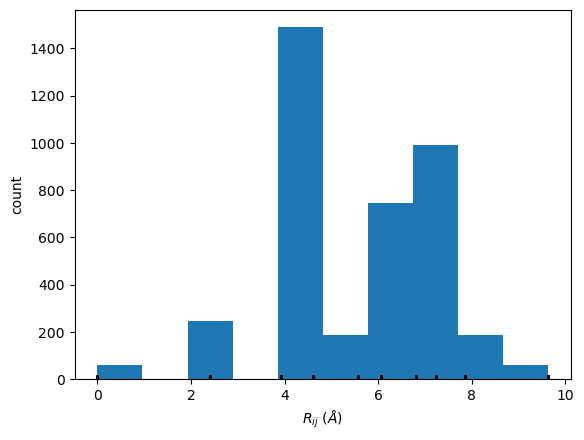

In [8]:
plt.hist(D.ravel());
plt.plot(D.ravel(), [0.1]* len(D.ravel()), '|', color='k');
plt.xlabel('$R_{ij}$ ($\AA$)')
plt.ylabel('count')

The first bin is the self distances (zero), the second bin is likely the covalently bonded Si atoms, lets see what happens if we take a cutoff just above that

In [9]:
r_cut = 3

And then find the number of neighbors

In [10]:
nn = (D < r_cut).sum(1) - 1 # subtract 1 for self distances
pd.Series(nn).value_counts()

4    59
3     4
Name: count, dtype: int64

So 59 of the atoms have 4 neighbors and 4 of them (those near the vacancy) have 3 neighbors. This seems reasonable. 

## Finding vacancy hopping

First lets bundle the code from above

In [16]:
def get_n_neighbors(atoms: ase.Atoms, r_cut: float = 3) -> np.ndarray[int]:
    D = atoms.get_all_distances(mic=True)
    nn = (D < r_cut).sum(1) - 1 # subtract 1 for self distances
    return nn

In [17]:
get_n_neighbors(atoms)

array([3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4])

And loop it over the trajectory, detecting: 

1. when the # neighbors is 'wrong' during a vacancy hop or similar
2. when the distirbution of # neighbors over atoms changes

In [45]:
correct_counts = pd.Series(nn).value_counts()
correct_counts

4    59
3     4
Name: count, dtype: int64

In [74]:
%%time
atoms = traj[0]
nn = get_n_neighbors(atoms)


# track whether a timestep has a 'wrong' or new configuration of neighbors
steps_wrong = np.zeros(len(traj))
steps_new = np.zeros(len(traj))
nn_all = [nn]

for t, atoms in enumerate(traj[1:]):
    print(f'{t}/{len(traj)}', end='\r')
    nn_new = get_n_neighbors(atoms)
    counts = pd.Series(nn_new).value_counts()

    # check whether we have the correct neighbor count distribution
    # handling the case where series comparison is invalid
    try: 
        is_correct = (counts == correct_counts).all()
    except: 
        is_correct = False
    

    # if we do have the correct neighbor count distribution
    # check if the atoms with these counts have changed
    if is_correct: 
        is_new = not (nn == nn_new).all()
        if is_new: 
            # count this as a new state
            steps_new[t] = 1
            # update the reference n_neighbor distribution
            nn = nn_new
    else: 
        steps_wrong[t] = 1

CPU times: user 30min 5s, sys: 58min 48s, total: 1h 28min 53s
Wall time: 4min 52s


In [75]:
steps_new.sum()

120.0

In [76]:
steps_wrong.sum()

15270.0

In [91]:
start = 5000
stop  = 8_000

In [92]:
t = np.arange(len(traj))

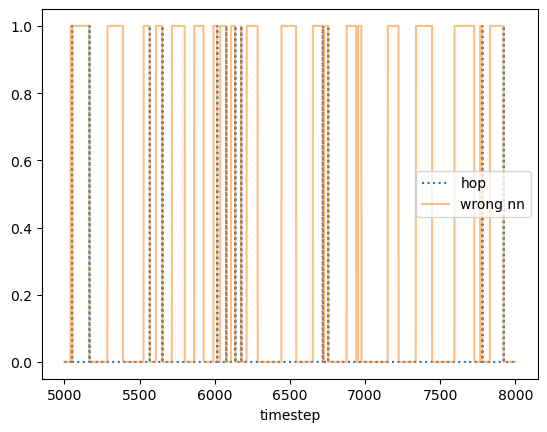

In [95]:
plt.plot(
    t[start:stop],
    steps_new[start:stop], 
    linestyle='dotted', 
    label='hop')
plt.plot(t[start:stop], 
         steps_wrong[start:stop], 
         alpha=0.5, label='wrong nn')
plt.xlabel('timestep')
plt.legend()

## Find the length of time between the hops

In [107]:
hop_indices = np.where(steps_new == 1)[0]
hop_indices

array([  133,   308,  2398,  2476,  3776,  3829,  4585,  4760,  5051,
        5167,  5568,  5652,  6017,  6077,  6137,  6177,  6719,  6755,
        7780,  7922,  8089,  8141,  8257,  8386,  8517,  8533,  9346,
        9393, 10187, 10243, 11818, 11868, 12557, 12601, 13786, 13809,
       13946, 13956, 14025, 14091, 14311, 14361, 14440, 14499, 15622,
       15658, 16941, 17051, 17246, 17288, 18476, 18529, 19985, 20036,
       20749, 21622, 21651, 21817, 21901, 23275, 23316, 23397, 23445,
       23524, 23746, 23767, 25177, 25189, 25262, 25332, 25483, 25546,
       25903, 25995, 26204, 26237, 27314, 27406, 28246, 28291, 28419,
       28542, 29302, 29373, 29412, 29606, 29643, 30443, 30532, 32205,
       32267, 32319, 32416, 32473, 32594, 32655, 32737, 32845, 33080,
       33089, 33255, 33301, 33487, 33521, 33541, 33717, 33730, 34958,
       35043, 35760, 35852, 36665, 36703, 36808, 36944, 38116, 38121,
       38175, 38655, 38738])

In [111]:
durations = np.diff(hop_indices)
durations

array([ 175, 2090,   78, 1300,   53,  756,  175,  291,  116,  401,   84,
        365,   60,   60,   40,  542,   36, 1025,  142,  167,   52,  116,
        129,  131,   16,  813,   47,  794,   56, 1575,   50,  689,   44,
       1185,   23,  137,   10,   69,   66,  220,   50,   79,   59, 1123,
         36, 1283,  110,  195,   42, 1188,   53, 1456,   51,  713,  873,
         29,  166,   84, 1374,   41,   81,   48,   79,  222,   21, 1410,
         12,   73,   70,  151,   63,  357,   92,  209,   33, 1077,   92,
        840,   45,  128,  123,  760,   71,   39,  194,   37,  800,   89,
       1673,   62,   52,   97,   57,  121,   61,   82,  108,  235,    9,
        166,   46,  186,   34,   20,  176,   13, 1228,   85,  717,   92,
        813,   38,  105,  136, 1172,    5,   54,  480,   83])

In [112]:
durations = hop_indices[0] + list(durations)

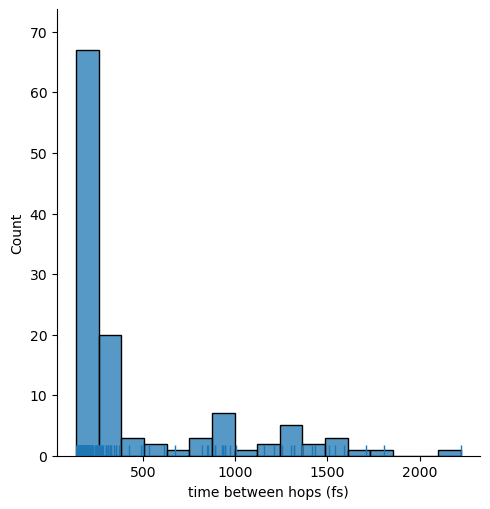

In [122]:
sns.displot(durations, rug=True)
plt.xlabel('time between hops (fs)');

That looks pretty good!